1. 使用pandas加载和处理时间序列  
2. 时间序列自相关性分析
3. 如何检验时间序列的稳定性？
4. 如何使得一个时间序列变得平稳？
5. 实现时间序列的预测

## 使用pandas加载和处理时间序列

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [3]:
data = pd.read_csv('Airpassengers.csv')

In [4]:
print(data.head())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


In [6]:
print('Data Types:')
print(data.dtypes)

Data Types:
Month          object
#Passengers     int64
dtype: object


In [8]:
dateparse = lambda dates:pd.datetime.strptime(dates,'%Y-%m')
data = pd.read_csv('Airpassengers.csv',
                   parse_dates = ['Month'], #需要处理的特征
                   index_col = 'Month', #索引
                   date_parser = dateparse) #特征处理方式

In [9]:
print(data.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [10]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [11]:
# 转化为序列对象
ts = data['#Passengers']
print(ts.head())

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


### 两种索引方式

In [12]:
#将字符串常量作为索引
print(ts['1949-01-01'])

112


In [13]:
#导入datetime库并且使用datetime方法
from datetime import datetime
print(ts[datetime(1949,1,1)])

112


In [14]:
print(ts[:'1949-05-01']) #注意这里5月1号的数据也是包含着的

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


In [15]:
print(ts['1949'])

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64


## 时间序列自相关性分析

使用时滞图来观察时间序列的自相关性  
时滞图把时间序列的值及相同序列在时间轴上后延的值放在一起展示

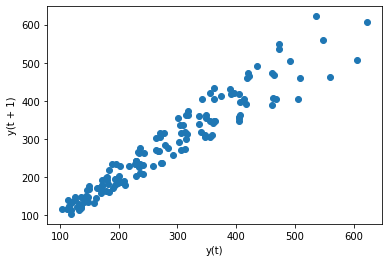

In [56]:
from pandas.plotting import lag_plot
lag_plot(ts)

发现数据在对角线附近聚集，存在明显的正相关性，符合时间序列要求，可以使用相关模型进行预测

## 如何检验一个时间序列的平稳性

/Users/jiangdonglei/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


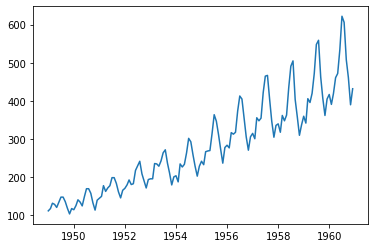

In [16]:
plt.plot(ts)

随着季节性的变动，飞机乘客的数量总体上是不断增长的

两种方法检验平稳性

绘制滚动统计指标:我们可以绘制移动平均数和移动方差，观察它是否随着时间变化。  
t时刻起，一个窗口范围内的所有数据的平均数或方差。  
然后移动窗口到t+1时刻。
  
Dickey-Fuller test:检测序列平稳性，先做一个待验假设，时间序列是不平稳的。  
1.测试结果包含Test Statistic（测试统计量）和一些Critical Values（置信区间的临界值）组成。如果测试统计量小于临界值，我们可以拒绝待验假设，并认为序列是稳定的。  
2.如果p-value接近0，四位小数左右。我们可以拒绝待验假设，并认为序列是稳定的。

In [17]:
from statsmodels.tsa.stattools import adfuller

In [19]:
def test_stationarity(timeseries):
    rolmean = pd.Series(timeseries).rolling(window = 12).mean() #移动平均数
    rolstd = pd.Series(timeseries).rolling(window = 12).std() #移动标准差
    
    # 绘制滚动统计指标
    orig = plt.plot(timeseries,color = 'blue',label = 'Original')
    mean = plt.plot(rolmean,color = 'red',label = 'Rolling Mean')
    std = plt.plot(rolstd,color = 'black',label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    # Dickey-Fuller测试
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic',
                                              'p-value',
                                              '#Lags Used',
                                              'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

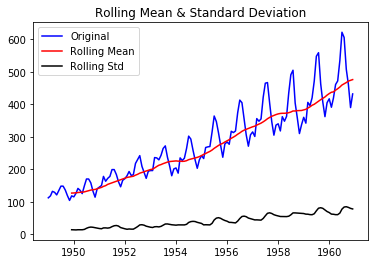

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [20]:
test_stationarity(ts)

Test Statistic比三个Critical Value值都要大  
p-value不接近0  
故为非平稳分布

## 如何使一个时间序列趋于平稳

使时间序列不稳定原因  
1.趋势：均值随时间变化而变化  
2.季节性：特定时间帧的变化。比如在特定日期消费增多，因为发工资了

### 估计和消除趋势

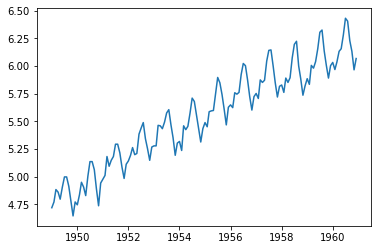

In [21]:
ts_log = np.log(ts)
plt.plot(ts_log)

对趋势建模，并将它从序列中删除

### 移动平均

取12个月的平均数

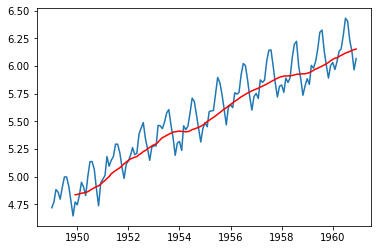

In [22]:
moving_avg = pd.Series(ts_log).rolling(12).mean() # 前12个月的平均
plt.plot(ts_log)
plt.plot(moving_avg,color = 'red')

In [23]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

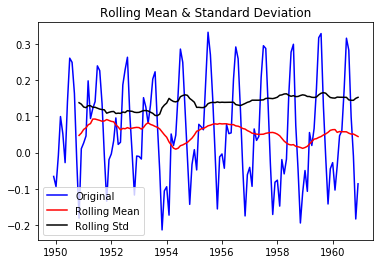

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [24]:
ts_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(ts_log_moving_avg_diff)

滚动平均值出现轻微的变化，没有明显的趋势  
检验统计值比5%的临界值小 我们可以在95%的置信区间认为它是平稳序列

### 指数加权移动平均

凸优化中的梯度下降方法优化方法中的动量法也是指数加权平均  
给最近的值赋予更高的权重

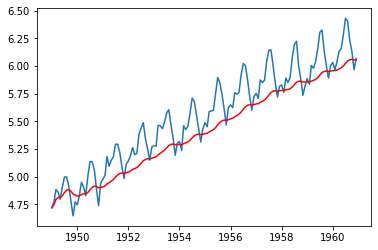

In [25]:
expweighted_avg = pd.Series(ts_log).ewm(halflife = 12).mean() 
# exp weight mean
# halflife使用半衰期来定义指数衰减量
plt.plot(ts_log)
plt.plot(expweighted_avg,color = 'red')

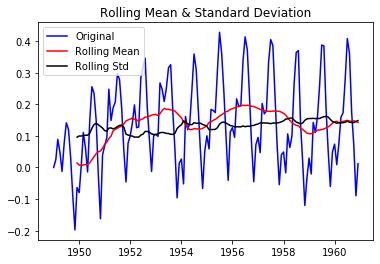

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [27]:
ts_log_ewma_diff = ts_log - expweighted_avg
test_stationarity(ts_log_ewma_diff)

检验统计值比1%的临界值小

### 消除趋势和季节性

在高季节性的情况下，讨论两种消除趋势和季节性的方法  
1.差分：取一个特定时间间隔的差值  
2.分解：建立有关趋势和季节性的模型然后从模型中删除它们

### 差分

取特定时刻和它前一个时刻的差值

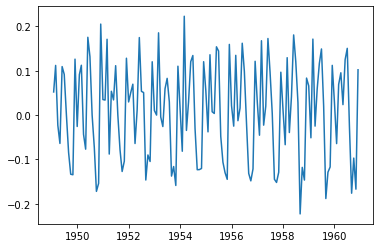

In [28]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

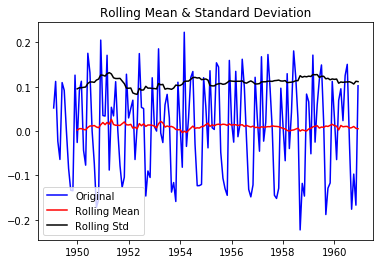

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [29]:
ts_log_diff.dropna(inplace = True)
test_stationarity(ts_log_diff)

统计检验值比10%的临界值小，可以在90%的置信区间认为时间序列是平稳的  
还可以取二阶或三阶差分

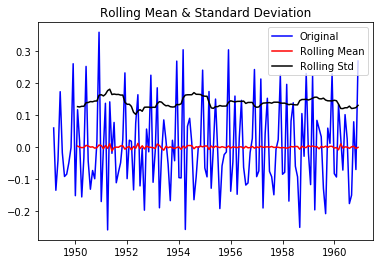

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


In [59]:
ts_log_diff_2 = ts_log_diff - ts_log_diff.shift() #二阶差分
ts_log_diff_2.dropna(inplace = True)
test_stationarity(ts_log_diff_2)

### 分解

在这种方法中，趋势和季节性被分开建模，序列剩下部分被返回

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

In [31]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

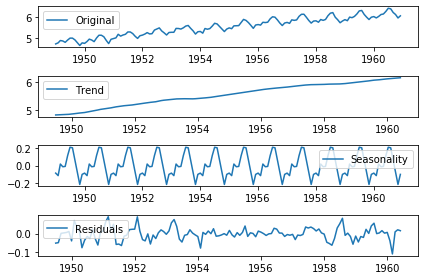

In [32]:
plt.subplot(411)
plt.plot(ts_log,label = 'Original')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend,label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal,label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual,label = 'Residuals')
plt.legend(loc = 'best')

plt.tight_layout()

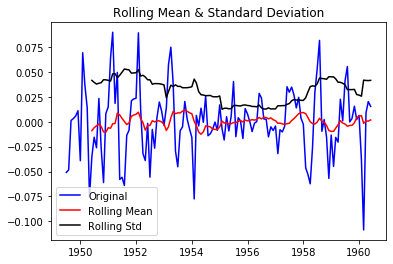

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [33]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace = True)
test_stationarity(ts_log_decompose)

统计检验值明显小于1%的临界值，这样的时间序列是非常接近平稳的

## 实现时间序列的预测

在完成了趋势和季节性估计和消除技术后，有两种情况  
1.不含依赖值的严格平稳序列。可以将残差作为白噪音。非常罕见  
2.序列含有明显依赖值。需要一些统计模型像ARIMA来预测数据

ARIMA：差分自回归移动平均  
三个系数p,q,d  
p：自回归项的数目，因变量的时滞，如果p等于5，使用x(t-1),...x(t-5)预测x(t)  
q：移动平均的数目，预测误差的时滞，如果q等于5，使用e(t-1),...e(t-5)预测x(t)  
e(i)是第i个时刻的移动平均和真实值的差值，相当于噪音  
d：差分次数

确定p和q值的方法  

自相关函数ACF(Auto correlation)：测量时间序列和自身之后版本之间的相关性。  
比如时滞为5，自相关函数会比较t1到t2时刻的序列和t1-5到t2-5时刻的序列  

偏自相关函数PACF(Partial Auto correlation)：时间序列和它自身滞后版本但已经排除了其他变量影响的相关性测试。  
如滞后值为5，它将检查相关性，但会删除从滞后值1到4得到的影响

In [34]:
from statsmodels.tsa.stattools import acf,pacf
lag_acf = acf(ts_log_diff,nlags = 20) # ts_log_diff差分
lag_pacf = pacf(ts_log_diff,nlags = 20,method = 'ols')

/Users/jiangdonglei/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [67]:
print("length of ts_log_diff:%d"%len(ts_log_diff))

length of ts_log_diff:143


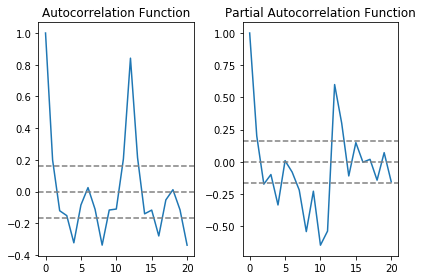

In [35]:
# Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0,linestyle = '--',color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)),linestyle = '--',color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)),linestyle = '--',color = 'gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0,linestyle = '--',color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)),linestyle = '--',color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)),linestyle = '--',color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

在这个图中，0旁边的两条虚线之间代表置信区间，这些可以用来确定p和q值  
p：偏自相关函数图中，第一次截取上层置信区间的所在位置是滞后值。p=2  
q：自相关函数图中，第一次截取上层置信区间所在位置是滞后值。q=2

In [60]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

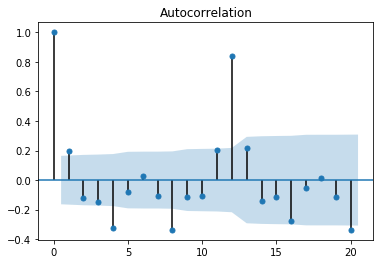

In [63]:
plot_acf(ts_log_diff,lags = 20)
plt.show()

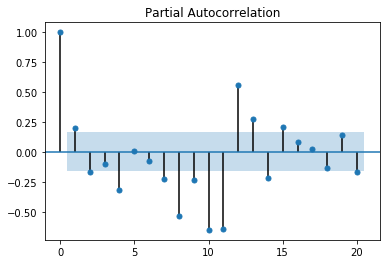

In [64]:
plot_pacf(ts_log_diff,lags = 20)
plt.show()

### AR模型

In [38]:
from statsmodels.tsa.arima_model import ARIMA

/Users/jiangdonglei/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/jiangdonglei/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS:1.5023')

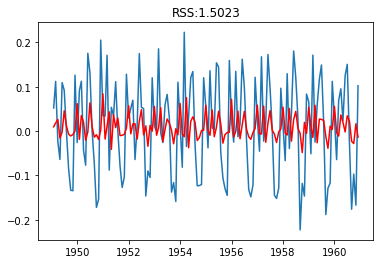

In [40]:
model = ARIMA(ts_log,order = (2,1,0)) # p,d,q
results_AR = model.fit(disp = -1)
plt.plot(ts_log_diff) #差分模型
plt.plot(results_AR.fittedvalues,color = 'red')
plt.title('RSS:%.4f'%sum((results_AR.fittedvalues-ts_log_diff)**2))
# RSS指残差值而不是实际序列

### MA模型

/Users/jiangdonglei/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/jiangdonglei/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS:1.4721')

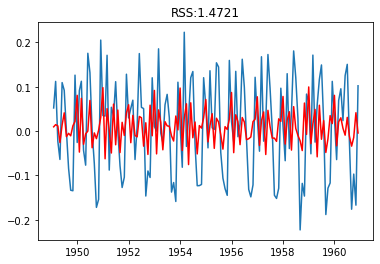

In [42]:
model = ARIMA(ts_log,order = (0,1,2))
results_MA = model.fit(disp = -1)
plt.plot(ts_log_diff) #差分模型
plt.plot(results_MA.fittedvalues,color = 'red')
plt.title('RSS:%.4f'%sum((results_MA.fittedvalues-ts_log_diff)**2))

### ARIMA模型

/Users/jiangdonglei/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/jiangdonglei/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS:1.0292')

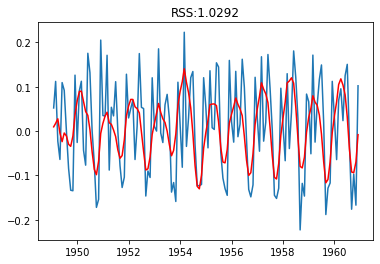

In [43]:
model = ARIMA(ts_log,order = (2,1,2))
results_ARIMA = model.fit(disp = -1)
plt.plot(ts_log_diff) #差分模型
plt.plot(results_ARIMA.fittedvalues,color = 'red')
plt.title('RSS:%.4f'%sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

### 使用AIC选择模型

In [66]:
print("results_AR.aic:%f"%results_AR.aic)
print("results_MA.aic:%f"%results_MA.aic)
print("results_ARIMA.aic:%f"%results_ARIMA.aic)

results_AR.aic:-237.604636
results_MA.aic:-240.378954
results_ARIMA.aic:-287.280808


ARIMA模型AIC分数最低，所以ARIMA模型最合适

### 回退至原始区间

In [44]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy = True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64


In [45]:
# 确定区间的累计总和
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [49]:
# 添加到基本值
predictions_ARIMA_log = pd.Series(ts_log.iloc[0],index = ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,
                                                  fill_value = 0)
print(predictions_ARIMA_log.head())

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773240
1949-05-01    4.768720
dtype: float64


Text(0.5, 1.0, 'RMSE:90.1050')

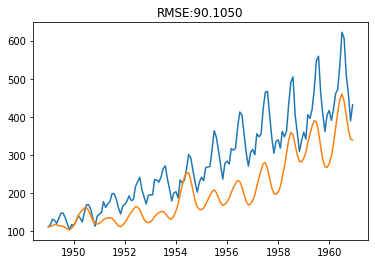

In [52]:
# 做指数操作
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE:%.4f'%np.sqrt(sum((predictions_ARIMA -ts)**2)/len(ts)))